**Instructors**: Prof. Keith Chugg (chugg@usc.edu) & Prof. Antonio Ortega (aortega@usc.edu)

**Teaching Assistant**: Alexios Rustom (arustom@usc.edu)

**Book**: Watt, J., Borhani, R., & Katsaggelos, A. K. (2020). Machine learning refined: Foundations, algorithms, and applications. Cambridge University Press.

**Notebooks**: Written by Alexios Rustom (arustom@usc.edu) and based on the following **Github repository**: [notebooks](https://github.com/jermwatt/machine_learning_refined/tree/gh-pages/presentations/2nd_edition/jupyter%20%2B%20reveal.js%20version)

#  Feature Engineering Selection

In [1]:
import numpy as np
import autograd.numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import seaborn as sns
from matplotlib import gridspec
import math
readDataPath = './readData/'

In [2]:
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

In [3]:
def plot_contour(g, xmin, xmax, ymin, ymax,num_contours, w_hist, x,y, plotWeightsFlag=False, lam=0):
    fig = plt.figure(figsize = (10,4.5))
    gs = gridspec.GridSpec(1, 1) 
    ax = plt.subplot(gs[0],aspect='equal');
    w1 = np.linspace(xmin,xmax,400)
    w2 = np.linspace(ymin,ymax,400)
    w1_vals, w2_vals = np.meshgrid(w1,w2)
    w1_vals.shape = (len(w1)**2,1)
    w2_vals.shape = (len(w2)**2,1)
    h = np.concatenate((w1_vals,w2_vals),axis=1)
    
    func_vals = np.asarray([ g(np.reshape(s,(2,1)),x,y, lam) for s in h])
    w1_vals.shape = (len(w1),len(w1))
    w2_vals.shape = (len(w2),len(w2))
    func_vals.shape = (len(w1),len(w2)) 

    levelmin = min(func_vals.flatten())
    levelmax = max(func_vals.flatten())
    cut = 0.4
    cutoff = (levelmax - levelmin)
    levels = [levelmin + cutoff*cut**(num_contours - i) for i in range(0,num_contours+1)]
    levels = [levelmin] + levels
    levels = np.asarray(levels)

    a = ax.contour(w1_vals, w2_vals, func_vals,levels = levels,colors = 'k')
    b = ax.contourf(w1_vals, w2_vals, func_vals,levels = levels,cmap = 'Blues')

    ax.set_xlabel('$w_0$',fontsize = 12)
    ax.set_ylabel('$w_1$',fontsize = 12,rotation = 0)
    ax.axhline(y=0, color='k',zorder = 0,linewidth = 0.5)
    ax.axvline(x=0, color='k',zorder = 0,linewidth = 0.5)
    if (plotWeightsFlag):
        arrows = True
        
        for j in range(len(w_hist)):  
            w_val = w_hist[j]

            colorspec =  '#2ca02c'
            # plot each weight set as a point
            ax.scatter(w_val[0],w_val[1],c = colorspec,s = 80,edgecolor = 'k', zorder = 3)
            if j > 0:
                pt1 = w_hist[j-1]
                pt2 = w_hist[j]
                
                pt_length = np.linalg.norm(pt1 - pt2)
                head_length = 0.1
                alpha = (head_length - 0.35)/pt_length + 1
                
                # if points are different draw error
                if np.linalg.norm(pt1 - pt2) > head_length and arrows == True:
                    if np.ndim(pt1) > 1:
                        pt1 = pt1.flatten()
                        pt2 = pt2.flatten()
                    
                    ax.arrow(pt1[0],pt1[1],(pt2[0] - pt1[0])*alpha,(pt2[1] - pt1[1])*alpha, head_width=0.1, head_length=head_length, fc='k', ec='k',linewidth=4,zorder = 2,length_includes_head=True)
                    ax.arrow(pt1[0],pt1[1],(pt2[0] - pt1[0])*alpha,(pt2[1] - pt1[1])*alpha, head_width=0.1, head_length=head_length, fc='w', ec='w',linewidth=0.25,zorder = 2,length_includes_head=True)
plt.show()

In [4]:
import autograd.numpy as np
from autograd import value_and_grad 
from autograd import hessian
from autograd.misc.flatten import flatten_func

def gradient_descent(g,alpha_choice,max_its,w,x,y, lam = 0):
    
    # flatten the input function to more easily deal with costs that have layers of parameters
    g_flat, unflatten, w = flatten_func(g, w) # note here the output 'w' is also flattened

    gradient = value_and_grad(g_flat)

    # run the gradient descent loop
    weight_history = []      # container for weight history
    cost_history = []        # container for corresponding cost function history
    alpha = 0
    for k in range(1,max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice
        
        # evaluate the gradient, store current (unflattened) weights and cost function value
        cost_eval,grad_eval = gradient(w,x,y, lam)
        weight_history.append(unflatten(w))
        cost_history.append(cost_eval)

        # take gradient descent step
        w = w - alpha*grad_eval
            
    # collect final weights
    weight_history.append(unflatten(w))
    # compute final cost function value via g itself (since we aren't computing 
    # the gradient at the final step we don't get the final cost function value 
    # via the Automatic Differentiatoor) 
    cost_history.append(g_flat(w,x,y, lam))  
    return weight_history,cost_history

- Feature engineering methods consist of an array of technicques that are applied to data *before* they are used by either supervsised or unsupervised models.  


- Some of these tools - like the *feature scaling* techniques properly *normalize* and cleans input data.  


- This provides a consistent preprocessing pipeline for learning, and drastically improves the efficacy of zero / first order local optimization methods in tuning machine learning models.

- Another branch of feature engineering focuses the development of data transformations that extract the *maximal* amount of useful information from input data.  


- For example in the case of  a two-class classification, these tools aim to extract critical elements of a dataset that ensure instances within a single class are seen as ”similar” while those from different classes are ”dissimilar”.  


- Designing such tools can require significant domain knowledge - or in other words, a rich set of experiences dealing witth particular kinds of data.  

### Feature selection

- Human beings can be an integral component of the machine learning paradigm, and in practice it can be crucial that individuals be able to interpret and / or derive insights from a fully machine learning model.  


- The *performance* of a model is a common and relatively easy metric for humans to interpret - i.e., does the model provide a good predictive result (where 'good' can mean it e.g., the learner achieves an agreed on benchmark value). 

- It can also be very useful to understand which *input features* were the most pertinent to achieving solid performance (remember each dimension of input is called a *feature* or *input feature* in the parlance of machine learning).  


- Doing this helps us refine our understanding of the nature of the problem at hand and - depending on the application - can help us make *informed decisions* based on the results of *supervised learning*.

- The fully tuned linear model for *supervised learning* takes the form 

\begin{equation}
\text{model}\left(\mathbf{x},\mathbf{w}^{\star}\right) =  \mathring{\mathbf{x}}_{\,}^T\mathbf{w}^{\star}   = w_0^{\star} + x_{1}^{\,}w_1^{\star} + x_{2}^{\,}w_2^{\star} + \cdots + x_{N}^{\,}w_N^{\star}.
\end{equation}


- where the weights $w_0^{\star},\,w_1^{\star}\,...,w_N^{\star}$ are been tuned by minimizing an appropriate cost function like e.g., the Least Squares when solving a regression problem of the Softmax cost when dealing with classification.  

- Understanding the intricate connections input features correspond with output naturally boils down to human analysis of the model's $N+1$ tuned weights.  


- However human beings often struggle to derive meaning from $N+1$ numbers (the value of all these weights) taken in all at once, and the idea of human interpretability quickly becomes untenable as $N$ grows.

- To aid in this human investigation we often perform what is called *feature selection* which helps highlight the weights corresponding to the most pertinent features of a, i.e., those that lead to strong performance.  


- In this Chapter we discuss two popular ways for performing feature selection: boosting and regularization.

## Feature Scaling via Standard Normalization

- we discuss two fundamental methods of *input normalization* - also called *feature scaling*.

- While this sort of feature engineering step provides several benefits to the learning process that we will see, here we focus on how it *substantially improves learning speed when using first order optimization algorithms*.  

- As such this 'optimization trick' proves quite useful in our current context of linear machine learning, and will prove especially valuable when we deal with nonlinear learning in the future - like e.g., *deep networks* - where training via first order methods is all but essential.



- We first explore the benefit of our first *feature scaling* technique: *standard normalization*.   We do this by exploring a number of simple supervised learning examples.

### Standard normalization of regression data

In [5]:
data = np.loadtxt( readDataPath + 'unnorm_linregress_data.csv',delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

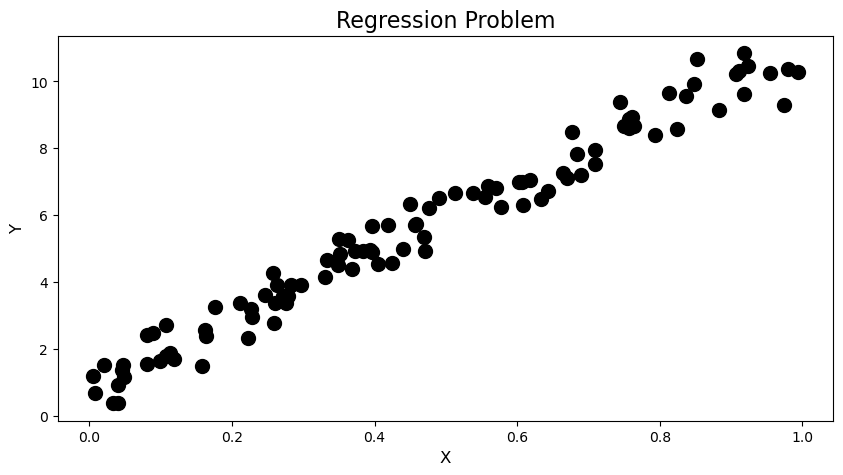

In [6]:
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Regression Problem', fontsize=16)
plt.show()

- A quick glance at the data and we know that - if tuned properly - a linear regression will fit to this dataset exceedingly well, as the data appears to be roughly distributed on a line.

- Since this is a low dimensional example with only two parameters to learn (the bias and slope of a best fit line) let us take a look at its associated Least Squares cost function.  

- Below we plot its contours in the usual fashion - with darker blue regions corresponding to larger points on the cost surface, and conversely lighter regions indicating lower points on the cost function.

In [7]:
def least_squares(w,x,y,lam=0):
    cost = np.sum((model(x,w) - y)**2)
    return cost/float(np.size(y))

In [8]:
g = least_squares
xmin = -12; xmax = 15; ymin = -5; ymax = 25; num_contours = 7;

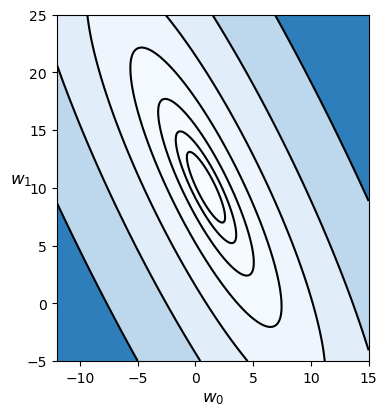

In [9]:
plot_contour(g, xmin, xmax, ymin, ymax,num_contours, [], x,y,plotWeightsFlag=False)

- Notice how **elliptical** the contours of this cost function are - these create a long narrow valley along the long axis of the ellipses.  


- While we can minimize this cost function using a variety of techniques, we will focus on employing gradient descent. 

- While we can certainly minimize this Least Squares cost using gradient descent, this algorithm progresses quite slowly when applied to minimize a cost functions like the one shown above (with its long narrow valley).  


- So unless we luck out and initialize directly along the *short axes* of such an elliptical contour-having cost function, gradient descent will need to take a large number of steps to reach an approximate global minimum.

- We illustrate this fact by showing a run of $100$ gradient descent steps initialized at the point $\mathbf{w}^0 = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$.  Here we use a fixed steplength parameter $\alpha = 10^{-1}$.  


- Here $10^{-1}$ was the largest value of $\alpha$ of the form $10^{-\gamma}$ we found that produced convergence from this initialization (larger values of $\alpha$ caused gradient descent to diverge).  

In [10]:
g = least_squares; w = np.array([0.0,0.0])[:,np.newaxis]; max_its = 100; alpha_choice = 10**(-1);

In [11]:
weight_history_1,cost_history_1 = gradient_descent(g,alpha_choice,max_its,w,x,y)

In [12]:
xmin = -3; xmax = 7; ymin = -1; ymax = 12; num_contours = 7

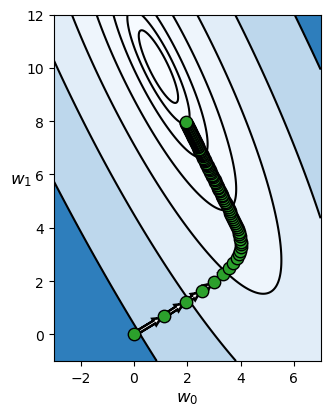

In [13]:
plot_contour(g, xmin, xmax, ymin, ymax,num_contours, w_hist = weight_history_1, x = x, y = y, plotWeightsFlag=True)

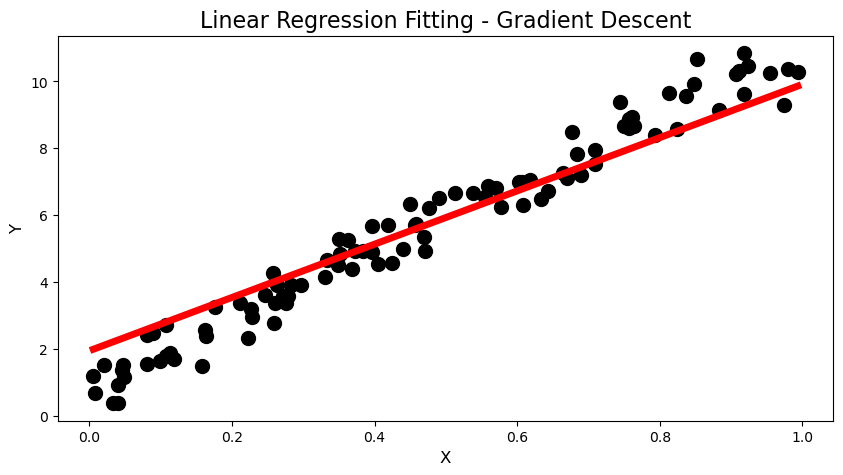

In [14]:
ind = np.argmin(cost_history_1)
least_weights_1 = weight_history_1[ind]
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Linear Regression Fitting - Gradient Descent', fontsize=16)
x_line = np.linspace(min(x[0]),max(x[0]),1000).reshape((1,1000))
y_line = model(x_line,least_weights_1)
plt.plot(x_line[0],y_line[0],'r-',linewidth=5)
plt.show()

- We can actually make an extremely simple adjustment of the data ameliorates this issue significantly, altering the shape of our Least Squares cost function so that its contours are much more *circular* (thus making it considerably easier for gradient descent to find global minima).  


- This simple adjustment is called *standard normalization*.  In particular, we normalize our inputs to have *zero mean and unit standard deviation*. 

- What does this look like?  Well we just replace each input $x_p$ point with its mean centered unit deviation analog as 

\begin{equation}
x_p \longleftarrow \frac{x_p - \mu}{\sigma}
\end{equation}

- where the sample mean of the inputs $\mu$ and the sample standard deviation of the inputs $\sigma$ are defined as 

\begin{equation}
\mu = \frac{1}{P}\sum_{p=1}^{P}x_p \qquad  \sigma = \sqrt{\frac{1}{P}\sum_{p=1}^{P}\left(x_p - \mu \right)^2}.
\end{equation}

- This simple normalization scheme is often called *standard normalization*.



- As we will see below for the particular dataset we are currently studying, this simple normalization 'trick' has a profound impact on the shape of our cost function. 


- Also note: this normalization scheme is *invertible*, meaning that after performing it we can always return to our original data by simple re-multiplying a normalized input by the original standard deviation and adding the original mean.  

In [15]:
# standard normalization function - returns functions for standard normalizing and reverse standard
# normalizing an input dataset x
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_stds = np.std(x,axis = 1)[:,np.newaxis]   

    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(x_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((x_stds.shape))
        adjust[ind] = 1.0
        x_stds += adjust

    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds

    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

In [16]:
# return normalization functions based on input x
normalizer,inverse_normalizer = standard_normalizer(x)

# normalize input by subtracting off mean and dividing by standard deviation
x_normalized = normalizer(x)

- Now we form a Least Squares cost function with our normalized input, with the output un-changed.


- With our cost function formed we now plot its contours, just as done previously.  


- As you can see - amazingly - the contours of this Least Squares cost (with normalized input) are perfectly circular.  


- No long narrow valleys can ever exist in such a function, and so gradient descent can much more rapidly minimize this cost.

In [17]:
def least_squares_normalizedInput(w,x,y, lam=0):
    cost = np.sum((model(x_normalized,w) - y)**2)
    return cost/float(np.size(y))

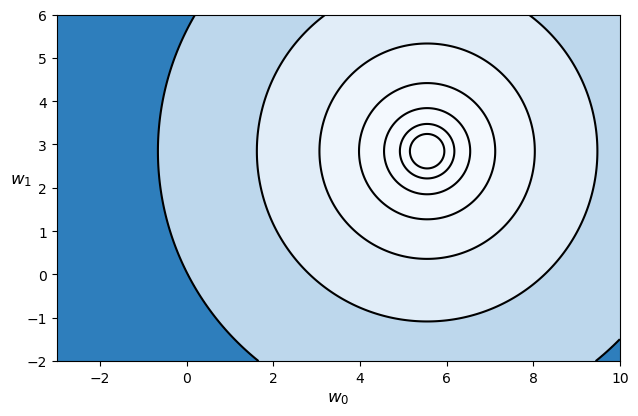

In [18]:
g = least_squares_normalizedInput; xmin = -3; xmax = 10; ymin = -2; ymax = 6; num_contours = 7;
plot_contour(g, xmin, xmax, ymin, ymax,num_contours, w_hist = [], x=x_normalized, y=y, plotWeightsFlag=False, lam=0)

In [19]:
w = np.array([0.0,0.0])[:,np.newaxis]; max_its = 20; alpha_choice = 10**(-1);

In [20]:
weight_history_2,cost_history_2 = gradient_descent(g,alpha_choice,max_its,w,x_normalized,y, lam=0)

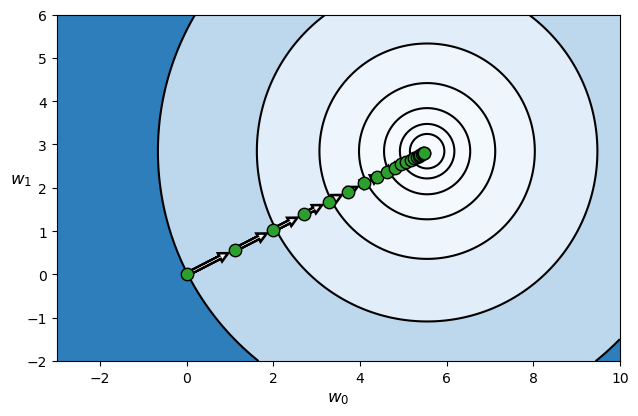

In [21]:
plot_contour(g, xmin, xmax, ymin, ymax,num_contours, w_hist = weight_history_2, x=x_normalized, y=y, plotWeightsFlag=True, lam=0)

- Using only a quarter of the number of descent steps - with precisely the same setup as previously - we get *much closer* to the cost function minimum!  

- Let us plot the fit associated with the final set of weights (the final red point above) on our original dataset below.   

- Notice that in order to make this plot we must treat each new *input test point* on the linear predictor precisely as we treated our original input: i.e., we must subtract off the same mean and divide off the same standard deviation.  

- Thus with our fully tuned parameters $w_0^{\star}$ and $w_1^{\star}$ our linear predictor for any input point $x$ is, instead of $ w_0^{\star} + w_1^{\star}x^{\,}$, now

\begin{equation}
\text{normalized predictor}\left(x\right) = w_0^{\star} + w_1^{\star}\left(\frac{x - \mu}{\sigma}\right).
\end{equation}

- Again - since we normalized the input data we trained on, we must normalize any new input point we shove through our trained linear model.


- The final predictor - plotted below in red - is far superior to the one we found previously, where we took $5$ times as many gradient descent steps, prior to normalizing the input data.  

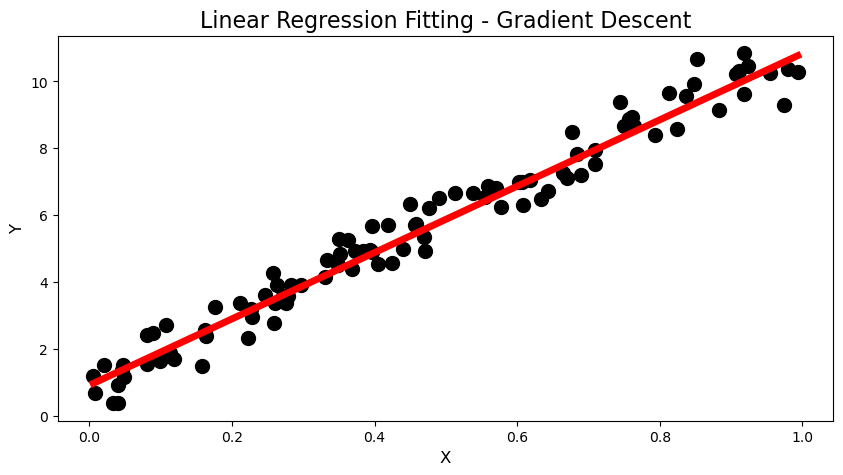

In [22]:
ind = np.argmin(cost_history_2)
least_weights_2 = weight_history_2[ind]
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Linear Regression Fitting - Gradient Descent', fontsize=16)

x_line = np.linspace(min(x[0]),max(x[0]),1000).reshape((1,1000))

y_line = model(normalizer(x_line),least_weights_2)
plt.plot(x_line[0],y_line[0],'r-',linewidth=5)
plt.show()


In [23]:
data = np.loadtxt(readDataPath + 'highdim_multirange_linregress.csv',delimiter = ',')
x = data[:-1,:]
y = data[-1:,:]

In [24]:
g = least_squares; w = np.zeros((6,1)); max_its = 20; alpha_choice = 10**(-3);
weight_history_1,cost_history_1 = gradient_descent(g,alpha_choice,max_its,w,x,y, lam=0)

In [25]:
normalizer,inverse_normalizer = standard_normalizer(x)

# normalize input by subtracting off mean and dividing by standard deviation
x_normalized = normalizer(x)

g = least_squares_normalizedInput; w = np.zeros((6,1)); max_its = 20; alpha_choice = 10**(-1);
weight_history_2,cost_history_2 = gradient_descent(g,alpha_choice,max_its,w,x_normalized,y, lam=0)

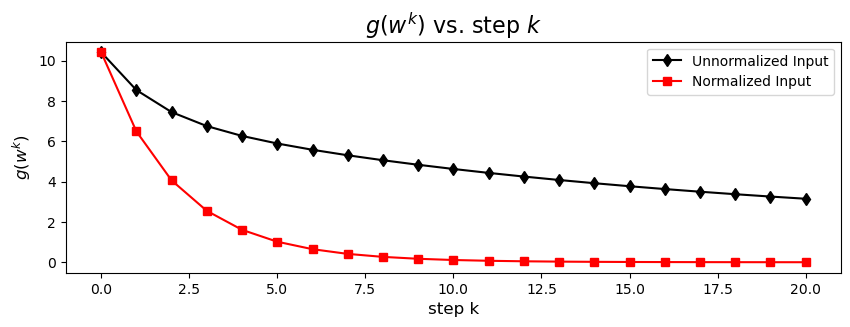

In [26]:
plt.figure(figsize=(10,3))

plt.plot(range(0,max_its+1), cost_history_1, 'dk-', label = 'Unnormalized Input')
plt.plot(range(0,max_its+1), cost_history_2, 'sr-',  label = 'Normalized Input')
plt.title(r'$g(w^k)$ vs. step $k$', fontsize=16)
plt.xlabel('step k', fontsize=12)
plt.ylabel(r'$g(w^k)$', fontsize=12)
plt.legend()
plt.show()

- To evaluate any new test point $\mathbf{x}$ - using our fully tuned parameters $w_0^{\star},w_1^{\star},...,w_N^{\star}$, we have to treat it as we did our training data.


- That is, we must normalize each input feature using the same statistics we computed on the training data above.

$$
\text{model}\left(\mathbf{x}\right) = w_0^{\star} + w_1^{\star}\left(\frac{x_1 - \mu_1}{\sigma_1}\right) + \cdots + w_N^{\star}\left(\frac{x_N - \mu_N}{\sigma_N}\right).$$

###  Standard normalization of classification data

In [27]:
data = np.loadtxt(readDataPath + '2d_classification_data_v1.csv',delimiter = ',')
x = data[:-1,:] + 4
y = data[-1:,:] 
y[0,-1] = -1
data = np.vstack((x,y))
assert x.shape == y.shape, f'Shape mismatch between X and Y'

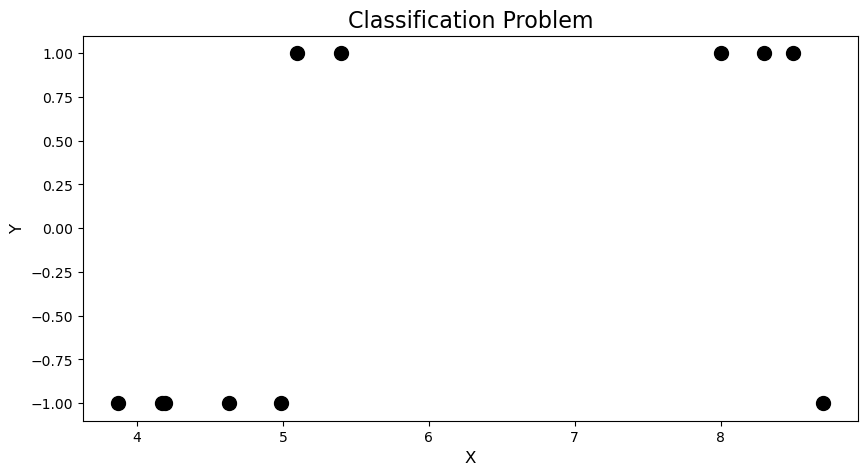

In [28]:
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title('Classification Problem', fontsize=16)
plt.show()

- Since we only need properly tune two parameters in learning a linear classifier for this dataset, we can visualize any classification cost function over it.  


- Below we show the contour plot of the softmax cost over the above dataset.


- The contours of this function are extremely long and narrow 


- And so we can predict that gradient descent will struggle immensely (zig-zagging very slowly) in determining the global minimum.

In [29]:
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

In [30]:
def softmax(w,x,y, lam=0):
    cost = np.sum(np.log(1 + np.exp(-y*model(x,w))))
    return cost/float(np.size(y))

In [31]:
def counting_cost(w,x,y):
    cost = np.sum((np.sign(model(x,w)) - y)**2)
    return 0.25*cost 

In [32]:
g = softmax
xmin = -100; xmax = 100; ymin = -30; ymax = 40; num_contours = 5;

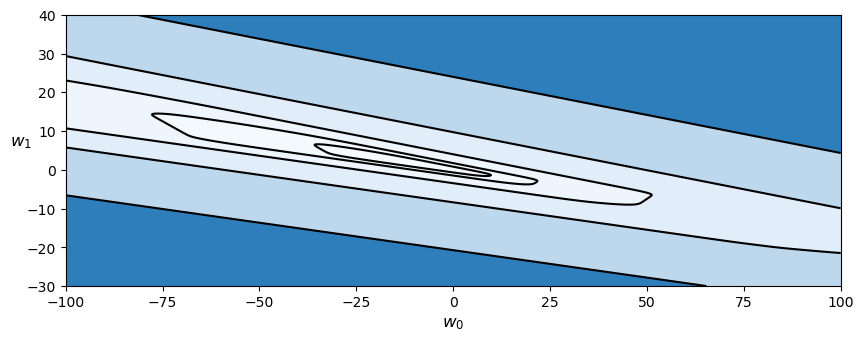

In [33]:
plot_contour(g, xmin, xmax, ymin, ymax,num_contours, w_hist = [],x=x, y=y, plotWeightsFlag=False, lam=0)

- We can confirm this intuition by making a run of gradient descent - which we do below. 


- Beginning at the point $\mathbf{w} = \begin{bmatrix} 20 \\ 30 \end{bmatrix}$ we visualize $100$ steps of gradient descent with a fixed steplength $\alpha = 1$.  


- This was the largest steplength size of the form $10^{-\gamma}$ with $\gamma$ an integer that we found that did not cause gradient descent to diverge here.

 

In [34]:
g = softmax; w = np.array([20.0,30.0])[:,np.newaxis]; max_its = 100; alpha_choice = 1;
weight_history_1,cost_history_1 = gradient_descent(g,alpha_choice,max_its,w,x,y, lam=0)
count_history_1 = [counting_cost(v,x,y) for v in weight_history_1]

In [35]:
xmin = -50; xmax = 25; ymin = -35; ymax = 40; num_contours = 5

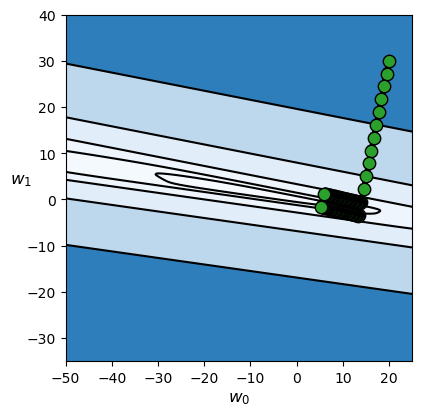

In [36]:
plot_contour(g, xmin, xmax, ymin, ymax,num_contours, w_hist = weight_history_1,x=x, y=y, plotWeightsFlag=True, lam=0)

- We can see that we still have a long way to travel to reach the minimum of the cost function, and that these steps will continue to zig-zag considerably. 

- Below we plot the logistic sigmoid given by the final set of weights learned in this run of gradient descent.


- Precisely those associated with the final red point plotted on the contour plot above.


 - And since these weights lie so far from the minimum we learn a poor classifier here. 

In [37]:
def model_classification_NegativePositiveLabel(x_p,w):
    # compute linear combination and return
    a = w[0] + np.dot(x_p.T,w[1:])
    predictions = [math.tanh(l) for l in a] #2*sigmoid(l)-1
    return predictions

In [38]:
ind = np.argmin(count_history_1)
best_weights_1 = weight_history_1[ind]

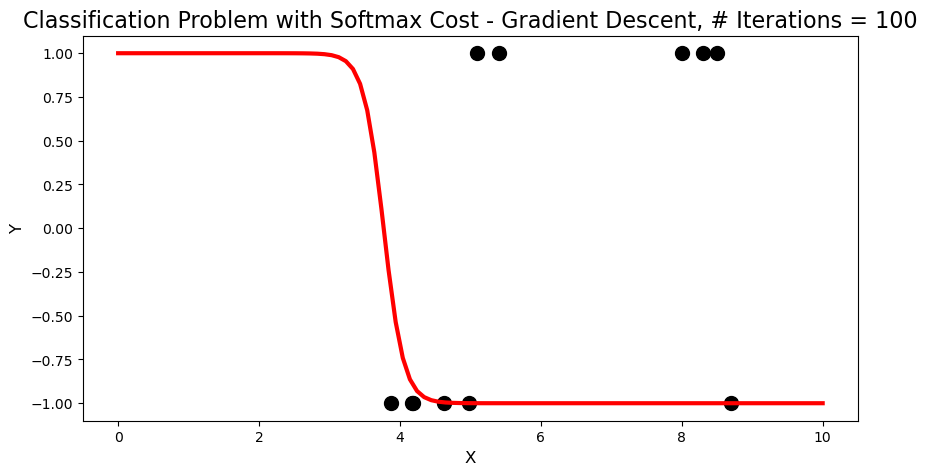

In [39]:
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title("Classification Problem with Softmax Cost - Gradient Descent, # Iterations = {}".format(max_its), fontsize=16)
x_line = np.linspace(0,10,100).reshape((1,100))
y_line = model_classification_NegativePositiveLabel(x_line,best_weights_1)
plt.plot(x_line[0],y_line,'r-',linewidth=3)
plt.show()

- *Standard normalization* provides precisely the same benefit we saw above for any learning problem, in particular two class linear classification.


- As with regression, this simple normalization 'trick' has a profound impact on the shape of our cost function.   


- As with regression, it tends to "round out" the contours of the cost, making it much easier to minimize properly.

- Lets now examine the contours of the softmax cost function using the normalized input.  


- As we can see below, the contours of this cost function are drastically improved.

In [40]:
normalizer,inverse_normalizer = standard_normalizer(x)

x_normalized = normalizer(x)

In [41]:
xmin = -25; xmax = 23; ymin = -11; ymax = 38; num_contours = 5; 

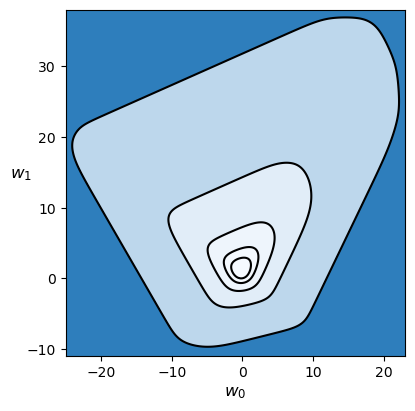

In [42]:
plot_contour(g, xmin, xmax, ymin, ymax,num_contours, w_hist = [],x=x_normalized, y=y, plotWeightsFlag=False, lam=0)

- Now we make a run of gradient descent to find an approximate global minimum of this softmax cost.  


- We will initialize at precisely the same point as was done previously.

In [43]:
g = softmax; w = np.array([20.0,30.0])[:,np.newaxis]; max_its = 25; alpha_choice = 10;
weight_history_2,cost_history_2 = gradient_descent(g,alpha_choice,max_its,w, x_normalized, y, lam=0)
count_history_2 = [counting_cost(v,x_normalized, y) for v in weight_history_2]

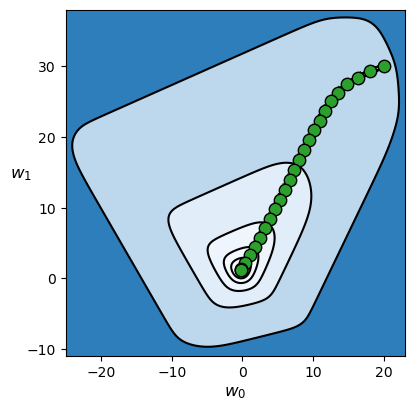

In [44]:
plot_contour(g, xmin, xmax, ymin, ymax,num_contours, w_hist = weight_history_2,x=x_normalized, y=y, plotWeightsFlag=True, lam=0)

- Here we used the largest steplength of the form $10^{-\gamma}$ possible, which in this instance is $\alpha = 10$.  


- Whenever we normalize input like this we can virtually always use a larger fixed steplength value.  


- Here - however - we will only use $25$ steps (one-fourth as many as we ran above in minimizing the softmax with un-normalized data).  


- Nonetheless even with so few steps - as can be seen below - we easily minimize the softmax cost and find an approximate global global minimum.

- In other words, after standard normalization we can use a much larger steplength and in far fewer steps we get *much closer* to the cost function minimum!  


- Let us plot the logistic cost associated with the final set of weights (the final red point above) with the original dataset.


- The final logistic predictor is far superior to the one we found previously, where we took $4$ times as many gradient descent steps, prior to normalizing the input data.  

In [45]:
ind = np.argmin(count_history_2)
best_weights_2 = weight_history_2[ind]

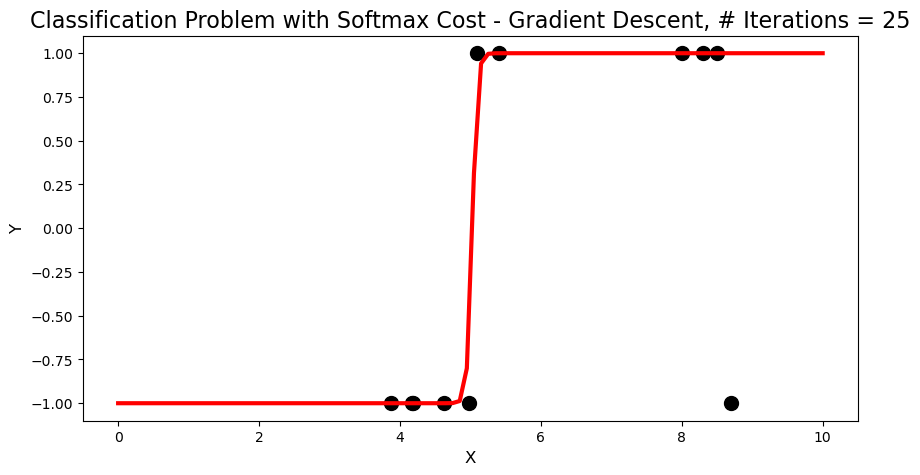

In [46]:
plt.figure(figsize=(10, 5))
plt.scatter(x,y,s=100,facecolors='k', edgecolors='k')
plt.xlabel('X', fontsize = 12)
plt.ylabel('Y', fontsize = 12)
plt.title("Classification Problem with Softmax Cost - Gradient Descent, # Iterations = {}".format(max_its), fontsize=16)
x_line = np.linspace(0,10,100).reshape((1,100))
y_line = model_classification_NegativePositiveLabel(normalizer(x_line),best_weights_2)
plt.plot(x_line[0],y_line,'r-',linewidth=3)
plt.show()

- As with linear regression, when dealing with $N$ dimensional input datasets we normalize each input feature precisely as we shown above with regression.


- Note to evaluate any new test point $\mathbf{x}$ - using our fully tuned parameters $w_0^{\star},w_1^{\star},...,w_N^{\star}$, we have to treat it as we did our training data. 

- That is we normalize each input feature using the same statistics we computed on the training data above as

$$
\text{model}\left(\mathbf{x}\right) = \text{tanh}\left(w_0^{\star} + w_1^{\star}\left(\frac{x_1 - \mu_1}{\sigma_1}\right) + \cdots + w_N^{\star}\left(\frac{x_N - \mu_N}{\sigma_N}\right)\right).$$

## Imputing Missing Values in a Dataset

- Real world data can contain *missing values* due to human error in collection, storage issues, faulty sensors, etc.,  


- If a supervised learning datapoint is missing its *output* value - e.g., if a classification datapoint is missing its *label* - there can be little we can do to salvage the datapoint, and usually such a corrupted datapoint is thrown away.  


- Likewise, if a large number of the values of an input are missing the data is best discarded.  

- However a datapoint whose input is missing just a handful of *input (feature) values* can be salvaged, and such points should be salvaged since data is often a scarce resource.  


- For us to be able to use a datapoint with missing entries in training any machine learning model we must *fill in missing input features with numerical values* 


- This is often called *imputing*.  


- But what values should we set missing entries too? 

### Imputing using the mean

- Suppose we have a set of $P$ inputs, each of which is $N$ dimensional, and say that the $j^{th}$ point has its missing $n^{th}$ input feature value.  


- In other words, the value $x_{j,n}$ is missing from our input data.  


- A reasonable value to fill for this missing entry is simply the *average of the dataset along this dimension*.


- This can roughly be considered the 'standard' value of our input along this dimension. 

- If in particular we use the *mean* $\mu_n$ of our input along this dimension (ignoring our missing entry $x_{j,n}$) we set $x_{j,n} = \mu_n$ where
 
\begin{equation}
\mu_n = \frac{1}{P-1} \sum_{\underset{p \neq j}{j=1}}^P x_{p,n}.
\end{equation}


- This is often called *mean-imputation*.

- Notice how, in mean-imputing $x_{p,n}$, that the mean value of the entire $n^{th}$ feature of the input with the inputed value *does not change*.  


- We can see this by simply computing the mean of the new $n^{th}$ input dimension as

$$
\frac{1}{P} \sum_{p=1}^P x_{p,n} = \frac{1}{P} \sum_{\underset{p \neq j}{j=1}}^P  x_{p,n} + \frac{1}{P} x_{j,n} \\= \frac{P - 1}{P} \frac{1}{P-1} \sum_{\underset{p \neq j}{j=1}}^Px_{p,n} + \frac{1}{P} x_{j,n} = \frac{P - 1}{P} \mu_n + \frac{1}{P} \mu_n = \mu_n.
$$

- Also notice that if we impute missing values of a dataset *using the mean along each input dimension* that if we then *standard normalize* this dataset, *all values imputed with the mean become exactly zero*.  


- Because the mean of an input feature that has been imputed with mean values does not change, when we *mean-center* the dataset (the first step in standard normalization) by *subtracting* the mean of this input dimension the resulting value becomes exactly zero

- Any model weight touching such a mean-imputed entry is then completely nullified numerically.  


- In other words, in training any mean-imputed value will not directly contribute to the tuning of its associated feature weight (provided the input has been standard normalized).  



- This is very desireable given that such values were missing to begin with.

- More generally if our input is missing multiple entries along this dimension we can just as reasonably replace each one with the mean along the $n^{th}$ feature, where in computing this mean we once again exclude missing values.  


- Again one can see that with these imputed values the *mean along this dimension does not change*.

## Feature Selection via Regularization

- With regularization we build a model by taking a 'top-down' view, and start off with a complete model that includes every one of our input features, and gradually remove input features of inferior importance.  

- We do this by adding a second function to our cost - called a *regularizer*  - that penalizes weights associated with less important input features.

### Regularization using simple vector norms

- The simple linear combination of two functions $f_1$ and $f_2$ 

\begin{equation}
f\left(\mathbf{w}\right) = f_1(\mathbf{w})+\lambda\,\,f_2(\mathbf{w})
\end{equation}

- is often referred to as *regularization*.  


- More specifically the function $f_2$ is called a *regularizer* in the jargon of machine learning, since by adding it to function $f_1$ we adjust its shape and $\lambda \geq 0$ is referred to as a penalty or regularization parameter.

- Here when $\lambda = 0$ the above combination reduces to $f_1$, and as we increase $\lambda$ the two functions $f_1$ and $f_2$ 'compete for dominance' in a linear combination.


- As we set $\lambda$ to larger and larger values the function $f_2$ dominates the combination, and eventually completely drowns out function $f_1$.  In this instance what we end up with is a highly positively scaled version of the regularizer $f_2$.

- Suppose we added a generic function $h\left(\cdot\right)$ to one of our supervised learning functions


- e.g., the Least Squares $g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}\left(\mathbf{x}_p^{\,},\mathbf{w}\right)  - \overset{\,}{y}_{p}^{\,}\right)^{2}$, giving a regularized linear combination of our cost function

\begin{equation}
f\left(\mathbf{w}\right) = g\left(\mathbf{w}\right) + \lambda \, h\left(\mathbf{w}\right).
\end{equation}

- By adding the regularizer $h\left(\mathbf{w}\right)$ to $g$ we alter its very nature, and in particular change the location of its minima.


- The larger we set the regularization parameter $\lambda$ the more the combination $f$ drifts towards a positively scaled version of the regularizer $h$ with minima that mirror closely those of $h$.


- By carefully engineering $h$ and the value of $\lambda$, we can construct a *regularized* form of the original cost function that retains the essence of $g$ in that it measures a regression error of a model against a set of input/output data points - but whose altered minima better reflect *only the most input features of a dataset*.

- One can do this just as easily with a *convex combination* of a cost function and another function $h$ - but the regularization paradigm is more popular in machine learning.


- A common choice for $h$ that achieve these desired aims is a  *vector norm* - in particular the so-called $\ell_1$ norm.  


- Remember that a vector norm is a simple function for measuring the *magnitude* or *length* of a vector.  


- Below we discuss several basic choices of vector norms, the latter two of which are very commonly used in machine learning applications.

#### <span style="color:#a50e3e;">Example. </span>  Regularization using the $\ell_0$ norm

- The $\ell_0$ vector norm, written as $\left \Vert \mathbf{w} \right \Vert_0$, measures 'magnitude' as

\begin{equation}
\left \Vert \mathbf{w} \right \Vert_0 = \text{number of non-zero entries of  } \mathbf{w}.
\end{equation}


- If we regularize a cost $g$ using it 

\begin{equation}
f\left(\mathbf{w}\right) = g\left(\mathbf{w}\right) + \lambda \,  \left \Vert \mathbf{w} \right \Vert_0
\end{equation}

- Here we are *penalizing* the regularized cost *for every non-zero entry of $\mathbf{w}$* since every non-zero entry *adds $+1$* to the magnitude $\left \Vert \mathbf{w} \right \Vert_0$.  


- Conversely then, in  *minimizing this sum*, the two functions $g$ and $\left \Vert \mathbf{w} \right \Vert_0$ 'compete for dominance' with $g$ wanting $\mathbf{w}$ to be resolved so that we attain a strong regression fit while the regularizer $\left \Vert \mathbf{w} \right \Vert_0$ *aims to determine a 'small' $\mathbf{w}$ that has as few non-zero elements as possible* (or - in other words - a weight vector $\mathbf{w}$ that is very *sparse*). 

#### <span style="color:#a50e3e;">Example. </span>  Regularization using the $\ell_1$ norm

- The $\ell_1$ vector norm, written as $\left \Vert \mathbf{w} \right \Vert_1$, measures 'magnitude' as

\begin{equation}
\left \Vert \mathbf{w} \right \Vert_1 = \sum_{n=0}^N \left \vert w_n \right \vert.
\end{equation}


- If we regularize a regression cost $g$ (or - as we will see - any machine learning cost) using it 

\begin{equation}
f\left(\mathbf{w}\right) = g\left(\mathbf{w}\right) + \lambda \,  \left \Vert \mathbf{w} \right \Vert_1
\end{equation}


- Notice what we are doing: we are *penalizing* the regularized cost *based on the sum of the absolute value of the entries of $\mathbf{w}$*. 

- Conversely then, in  *minimizing this sum*, the two functions $g$ and $\left \Vert \mathbf{w} \right \Vert_1$ 'compete for dominance' with $g$ wanting $\mathbf{w}$ to be resolved so that we attain a strong regression fit, while the regularizer $\left \Vert \mathbf{w} \right \Vert_1$ aims to determine a $\mathbf{w}$ that is small both in terms of the absolute value of each of its components, but also - because the $\ell_1$ norm is so closely related to the $\ell_0$ norm - one that has few non-zero entries and is quite *sparse*. 

#### <span style="color:#a50e3e;">Example. </span>  Regularization using the $\ell_2$ norm

- The $\ell_2$ vector norm, written as $\left \Vert \mathbf{w} \right \Vert_2$, measures 'magnitude' as

\begin{equation}
\left \Vert \mathbf{w} \right \Vert_2 = \sqrt{\left(\sum_{n=0}^N w_n^2 \right )}.
\end{equation}

- If we regularize a regression cost $g$ (or - as we will see - any machine learning cost) using it

\begin{equation}
f\left(\mathbf{w}\right) = g\left(\mathbf{w}\right) + \lambda \,  \left \Vert \mathbf{w} \right \Vert_2
\end{equation}

- Notice what we are doing: we are *penalizing* the regularized cost *based on the sum of squares of the entries of $\mathbf{w}$*.  

- Conversely then, in  *minimizing this sum*, the two functions $g$ and $\left \Vert \mathbf{w} \right \Vert_2$ 'compete for dominance' with $g$ wanting $\mathbf{w}$ to be resolved so that we attain a strong regression fit while the regularizer $\left \Vert \mathbf{w} \right \Vert_2$ aims to determine a $\mathbf{w}$ that is small in the sense that *all of its entries* have a small *squared* value. 

### Feature selection via $\ell_1$ regularization

- From the perspective of machine learning, by inducing the discovery of *sparse minima* the $\ell_0$ and $\ell_1$ regularizers help uncover the identity of a dataset's *most important features*:


- these are precisely the features associated with the non-zero feature-touching weights.  


- This makes both norms - at least in principle - quite appropriate for our current application.

- On the other hand, the drive for general 'smallness' induced by minimizing a cost with the $\ell_2$ regularizer means - provided $\lambda$ is set correctly - that typically *every* weight is included in the minima recovered.  


- This makes the $\ell_2$ intuitively less appealing for the application of feature selection (although it is used throughout machine learning as a regularizer for applications other than feature selection).

- Of the two sparsity-inducing norms described here the $\ell_0$ norm - while promoting sparsity to the greatest degree - is also the most challenging to employ since it is *discontinuous*.


- This makes the minimization of an $\ell_0$ regularized cost function quite difficult.  


- While the $\ell_1$ norm induces sparsity to less of a degree, it is *convex and continuous* and so we have no practical problem minimizing a cost function where it is used as regularizer.  


- Because of this practical advantage the $\ell_1$ norm is by far the more commonly used regularizer for feature selection.

- Finally, remember that when performing feature selection we are only interested in determining the importance of *feature-touching* weights $w_1,\,w_2,\,...,w_N$.


- So we only need regularize them (and not the bias weight $w_0$), and so our regularization will more specifically take the form

\begin{equation}
f\left(\mathbf{w}\right) = g\left(\mathbf{w}\right) + \lambda \,  \sum_{n=1}^N \left\vert w_n \right\vert.
\end{equation}


- And note here $g$ is any supervised learning cost function.  

- Using our individual notation for the bias and feature-touching weights 

\begin{equation}
\text{(bias):}\,\, b = w_0 \,\,\,\,\,\,\,\, \text{(feature-touching weights):} \,\,\,\,\,\, \boldsymbol{\omega} = 
\begin{bmatrix}
w_1 \\
w_2 \\ 
\vdots \\
w_N
\end{bmatrix}.
\end{equation}

- we can write this general $\ell_1$ regularized cost function equivalently as

\begin{equation}
f\left(b,\boldsymbol{\omega}\right) = g\left(b,\boldsymbol{\omega}\right)  + \lambda \,  \left\Vert  \boldsymbol{\omega} \right\Vert_1.
\end{equation}

### What value should $\lambda$ be set too?

- Because feature selection is done for the purposes of *human interpretation* the value of $\lambda$ can be based on several factors.  


- A benchmark value for $\lambda$ can be hand chosen based on the desire to explore a dataset, finding a value that provides sufficient sparsity while retaining a low cost value.  


- Finally, $\lambda$ can be chosen entirely based on the sample statistics of the dataset via a procedure known as *cross-validation*.

- Regardless of how we select $\lambda$, note that because we are trying to determine the *importance* of each input feature here that before we begin the process of regularization we *always need to standard normalize the input to our dataset*.  


- By normalizing each input feature distribution we can fairly compare each input feature's contribution and determine the importance of each.

#### <span style="color:#a50e3e;">Example. </span>  Exploring features for predicting housing prices via $\ell_1$ regularized regression

- In this example we use the Boston Housing dataset. 


- This dataset consists of $P=506$ datapoints with $N=13$ input features relating various statistics about homes in the Boston area to their median values (in U.S. dollars).  


- We use $\ell_1$ regularization with $50$ evenly spaced values for $\lambda$ in the range $\left[0, 130 \right]$.  

In [47]:
def model(x,w):
    a = w[0] + np.dot(x.T,w[1:])
    return a.T

In [48]:
def least_squares(w,x,y,lam):
    # compute cost
    cost = np.sum((model(x,w) - y)**2)
    
    # add regularizer 
    cost =  cost/float(np.size(y))+ lam*np.sum(np.abs(w[1:]))
    #cost += lam*np.sum(np.abs(w[1:]))
    # return average
    return cost#cost/float(np.size(y))

In [49]:
def standard_normalizer(x):
    # compute the mean and standard deviation of the input
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_stds = np.std(x,axis = 1)[:,np.newaxis]   
    
    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(x_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((x_stds.shape))
        adjust[ind] = 1.0
        x_stds += adjust

    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds

    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

In [50]:
csvname =  readDataPath + 'boston_housing.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:]

In [51]:
normalizer,inverse_normalizer = standard_normalizer(x)

x_normalized = normalizer(x)

In [52]:
lams = np.linspace(0,x.shape[0]*10,20)
num_rounds = len(lams)
w_init = 0.1*np.random.randn(x.shape[0] + 1,1); max_its=1000; alpha_choice=10**(-1);
cost_vals = []; weights = [];

for i in range(num_rounds):        
    # set lambda
    lam = lams[i]
    g = least_squares
    # load in current model
    w_hist,c_hist = gradient_descent(g,alpha_choice,max_its,w_init, x_normalized, y, lam)
    
    # determine smallest cost value attained
    ind = np.argmin(c_hist)            
    weight = w_hist[ind]
    cost_val = c_hist[ind]
    weights.append(weight)
    cost_vals.append(cost_val)
ind = np.argmin(cost_vals)
best_lam = lams[ind]
best_weights = weights[ind]

In [53]:
def plot_learnedWeights(lam, weights, cost_vals):
    index = np.where(lams==lam)[0][0]
    fig = plt.figure(figsize = (9,3))
    gs = gridspec.GridSpec(1,1) 
    ax = plt.subplot(gs[0])
    w_best = weights[index][1:]
    ax.axhline(c='k',zorder = 2)
    ax.bar(np.arange(1,len(w_best)+1).flatten(),np.array(w_best).flatten(), color='k', alpha=0.5)
    title1 = r'$\lambda = ' + str(np.round(lam,2)) + '$'
    costval = cost_vals[index][0]
    title2 = ', cost val = ' + str(np.round(costval,2))
    title = title1 + title2
    ax.set_title(title)
    ax.set_ylabel('learned weights')
    ax.set_xlabel('weight index')
    ax.set_xticks(np.arange(1,x.shape[0]+2))
    ax.set_xticklabels(np.arange(1,x.shape[0]+2))
    #ax.set_ylim([-3, 4])
    plt.show()
    

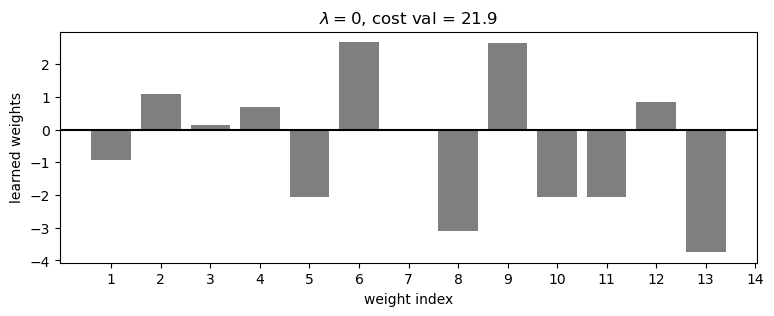

In [54]:
lam = 0;
plot_learnedWeights(lam, weights, cost_vals)

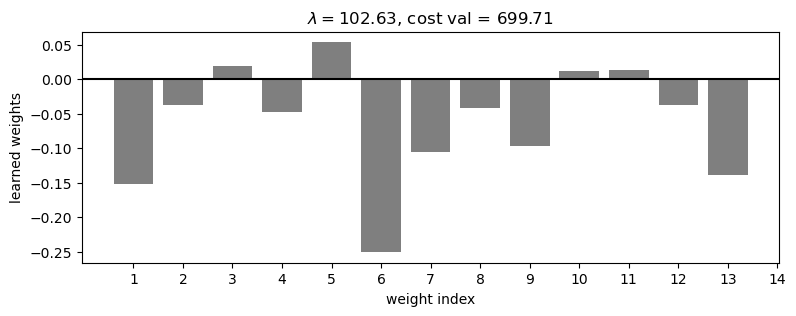

In [55]:
lam = lams[15];
plot_learnedWeights(lam, weights, cost_vals)

- As $\lambda$ is increased notice how many of the large (in magnitude) feature-touching weights seen when $\lambda = 0$ quickly disappear.